# EO Data Processing with the openEO MultiBackendJobManager

In this notebook, we will demonstrate how to use the [MultiBackendJobManager](https://open-eo.github.io/openeo-python-client/cookbook/job_manager.html) to set-up and track multiple jobs at once using OpenEO. 

This example will specifically focus on how to a manage a compositing workflow evaluated on various spatial locations. 

### Key features

1. Job Tracking: Keep track of jobs their statuses and results across different backends.
2. Error Handling: Customizable handling of job errors and completed jobs.
3. Database Support: Persist job metadata using CSV or Parquet files, allowing you to resume tracking after interruptions.


### Table of Contents

1. [Import Libraries and Define Constants](#import-libraries-and-define-constants)
2. [Creating the Jobs Database](#preparing-the-jobs-database)
3. [Creating the Job](#creating-the-job)
4. [Managing Jobs Using MultiBackendJobManager](#managing-jobs-using-multibackendjobmanager)


## Import Libraries and Define Constants

We will start by importing the necessary libraries and defining some constants for our compositing workflow.

In [7]:
import pandas as pd
import numpy as np
import datetime

from typing import Dict, Any
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
import rasterio

import openeo
from openeo.extra.job_management import MultiBackendJobManager


# Constants
BASE_SPATIAL_START = {"west": 664000.0, "south": 5611120.0, "crs": "EPSG:32631", "srs": "EPSG:32631"}
SPATIAL_WINDOW_SIZE = 10000  # 10 km in meters
SPATIAL_WINDOW_GAP = 10000   # 10 km gap

## Creating the Jobs Database
The `MultiBackendJobManager` uses a jobs database to set-up, start and monitor all desired jobs.
In what follows we will set up jobs database by populating it with all the varying input parameters for each job. 

In this example we will demonstrate how to set up the database using pandas. However, note that the jobs database can also be created manually if desired.

### Helper Function: Creating Spatial Extents
To automate the creation of our job database, we will define a few helper functions. 

The first helper function will generate a collection of spatial extents. Each spatial extent consists out of a 10km x 10km window.

In [8]:
def create_spatial_extent(offset_x: int, offset_y: int, base_extent: Dict[str, Any] = BASE_SPATIAL_START) -> Dict[str, Any]:
    """Create a spatial extent dictionary based on an offset for 10km by 10km windows."""
    return {
        "west": base_extent["west"] + offset_x * (SPATIAL_WINDOW_SIZE + SPATIAL_WINDOW_GAP),
        "south": base_extent["south"] + offset_y * (SPATIAL_WINDOW_SIZE + SPATIAL_WINDOW_GAP),
        "east": base_extent["west"] + (offset_x + 1) * SPATIAL_WINDOW_SIZE + offset_x * SPATIAL_WINDOW_GAP,
        "north": base_extent["south"] + (offset_y + 1) * SPATIAL_WINDOW_SIZE + offset_y * SPATIAL_WINDOW_GAP,
        "crs": base_extent["crs"],
        "srs": base_extent["srs"]
    }

### Helper Function: Prepare the Jobs Database
In this section, we prepare the jobs database through pandas. For each job we wish to run, we include all relevant input parameters.  Since, in this example, we only want to vary the location, the Database will solely contain the spatial extents of interest.

The helper function `prepare_jobs_db` creates this Database, defining spatial extents based on pre-defined offsets. 

In [11]:
def prepare_jobs_db(max_offset:int) -> pd.DataFrame:
    """Prepare a database using pandas, containing job configurations for benchmarking."""
    jobs = []

    # Create combinations for the spatial grid
    for offset_x in range(max_offset):
        for offset_y in range(max_offset):
            jobs.append({
                "spatial_extent": create_spatial_extent(offset_x, offset_y),
            })

    return pd.DataFrame(jobs)

jobs_database = prepare_jobs_db(max_offset = 3)
print(jobs_database)

                                      spatial_extent
0  {'west': 664000.0, 'south': 5611120.0, 'east':...
1  {'west': 664000.0, 'south': 5631120.0, 'east':...
2  {'west': 664000.0, 'south': 5651120.0, 'east':...
3  {'west': 684000.0, 'south': 5611120.0, 'east':...
4  {'west': 684000.0, 'south': 5631120.0, 'east':...
5  {'west': 684000.0, 'south': 5651120.0, 'east':...
6  {'west': 704000.0, 'south': 5611120.0, 'east':...
7  {'west': 704000.0, 'south': 5631120.0, 'east':...
8  {'west': 704000.0, 'south': 5651120.0, 'east':...


### Visualizing Spatial Extents

Here, we illustrate how the defined windows map across the area of interest.

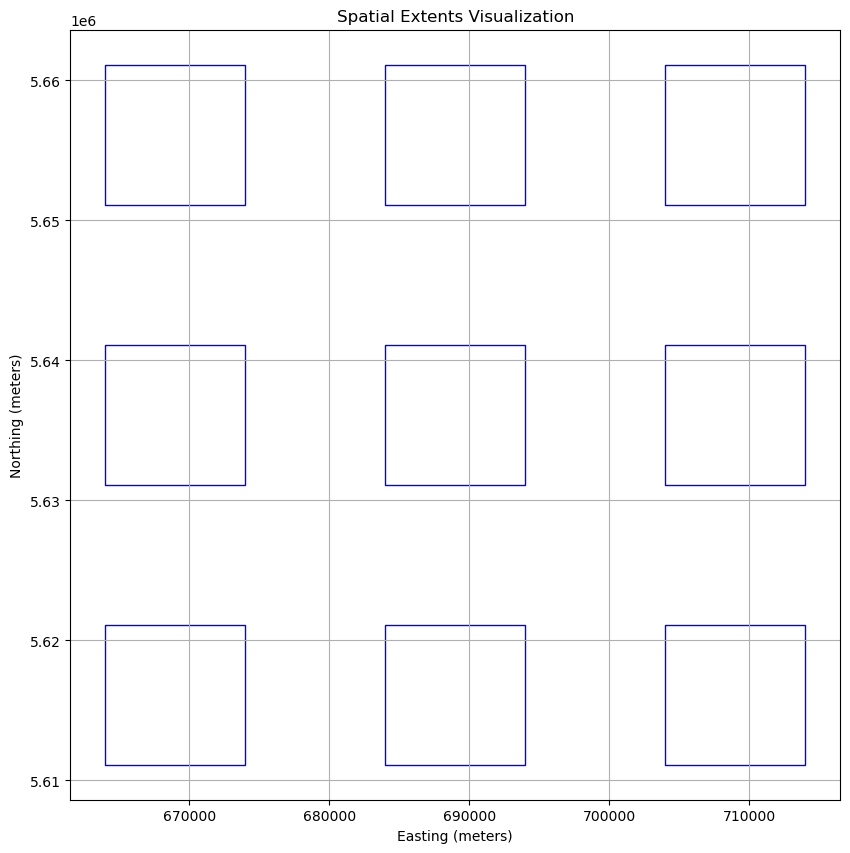

In [12]:
def visualize_spatial_extents(jobs_database: pd.DataFrame):
    """Visualize spatial extents from the given DataFrame and overlay images for finished jobs."""
    _, ax = plt.subplots(figsize=(10, 10))
    
    # Create a GeoDataFrame for spatial extents
    geometries = []
    for _, row in jobs_database.iterrows():
        extent = row["spatial_extent"]
        rectangle = box(extent["west"], extent["south"], extent["east"], extent["north"])
        geometries.append(rectangle)
    
    gdf = gpd.GeoDataFrame(geometry=geometries)
    
    # Plot the spatial extents
    gdf.plot(ax=ax, facecolor='none', edgecolor='blue')
    
    plt.xlabel("Easting (meters)")
    plt.ylabel("Northing (meters)")
    plt.title("Spatial Extents Visualization")
    plt.grid(True)
    plt.show()

# Example usage
visualize_spatial_extents(jobs_database)

## Creating the Job

The next step is to define a `start_job` function. This function will instruct the `MultiBackendJobManager` on how to initiate a new job on the selected backend. The `start_job` functionality should adhere to the following structure `_start_job(row: pd.Series, connection: openeo.Connection, **kwargs)_`.

In this example, the `MultiBackendJobManager` will iterate through the provided jobs database and run a basic compositing workflow for each individual row of the jobs database. 

While this example demonstrates a basic compositing workflow, the `MultiBackendJobManager` is capable of handling multiple high-computation jobs simultaneously. 


In [13]:
def start_job(row: pd.Series, connection: openeo.Connection, **kwargs) -> openeo.BatchJob:
    """Start a new job using the specified row out of the jobs data base and connection."""
    
    # Get the variable parameters from the dataframe
    spatial_extent = row["spatial_extent"]

    # Build the openEO process
    s2_cube = connection.load_collection(
        collection_id="SENTINEL2_L2A",
        spatial_extent=spatial_extent,
        temporal_extent=["2022-06-01","2022-09-01"],
        bands=["B02", "B03", "B04", "SCL"],
        properties={"eo:cloud_cover": lambda x: x.lte(60)}
    )

    # Mask out clouds
    s2_cube = s2_cube.process("mask_scl_dilation", data=s2_cube, scl_band_name="SCL").filter_bands(s2_cube.metadata.band_names[:-1])

    # Create monthly composites by taking the mean
    s2_cube = s2_cube.aggregate_temporal_period(
        period = "month",
        reducer = "mean"
    )

    # Fill gaps in the data using linear interpolation
    s2_cube = s2_cube.apply_dimension(
        dimension = "t",
        process = "array_interpolate_linear"
    )

    s2_cube.save_result(format = "GTiff")
    
    return s2_cube.create_job(
        title='MultiBackendJobManager - Example'
    )


## Managing Jobs Using MultiBackendJobManager

With our jobs database and job definition set up, we can now run the jobs using the `MultiBackendJobManager`. This involves defining a path to where we will store the job tracker which contains the job statuses and metadata.

### Steps to Run the Jobs:

1. Provide a path towards the job tracker:
   The predefined jobs database contains all the input parameters for the jobs we intend to run with the MultiBackendJobManager. Typically, this database will serve as the foundation for the job tracker. By specifying a unique path, the job tracker will be created, incorporating all the information from the original jobs database. 

   Aditionally, the job tracker will also include a 'status' column, allowing you to easily monitor which jobs have been created, are currently running, have finished, or encountered an error. Furthermore, job usage metrics are added as the job is finished.

   **Caution:**
   If the specified job tracker path, points to an existing jobs database (either a .csv or .parquet file), that file will be used as the job tracker, and the input jobs database will be disregarded.
   
<br>


2. Initialize the MultiBackendJobManager:
   We create an instance of the `MultiBackendJobManager` and add a backend of our choice, which will be responsible for executing the jobs.
   
   **Caution:**
   The number of parallel jobs refers to how many jobs the job manager tracks at once. However, the backend itself limits the actual number of jobs that can start and run at the same time to 2.

<br>

3. Run Multiple Jobs:
   Use `manager.run_jobs` to create the desired jobs and send them to the backend.
   The selected job tracker will be updated on the actual job statuses and usage metris.

In [ ]:
# Generate a unique name for the tracker
job_tracker = 'community_example_job_tracker.parquet'

# Initiate MultiBackendJobManager 
manager = MultiBackendJobManager()  
connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()
manager.add_backend("cdse", connection=connection, parallel_jobs=2)

# Run the jobs
manager.run_jobs(df=jobs_database, start_job=start_job, job_db=job_tracker)

Authenticated using refresh token.


## Visualise Output

Once a job is finalized, the output is automatically downloaded into a dedicated folder named after the job ID. The data is saved in GeoTIFF format.

With this data in hand, we can now visualize the results of our various jobs.

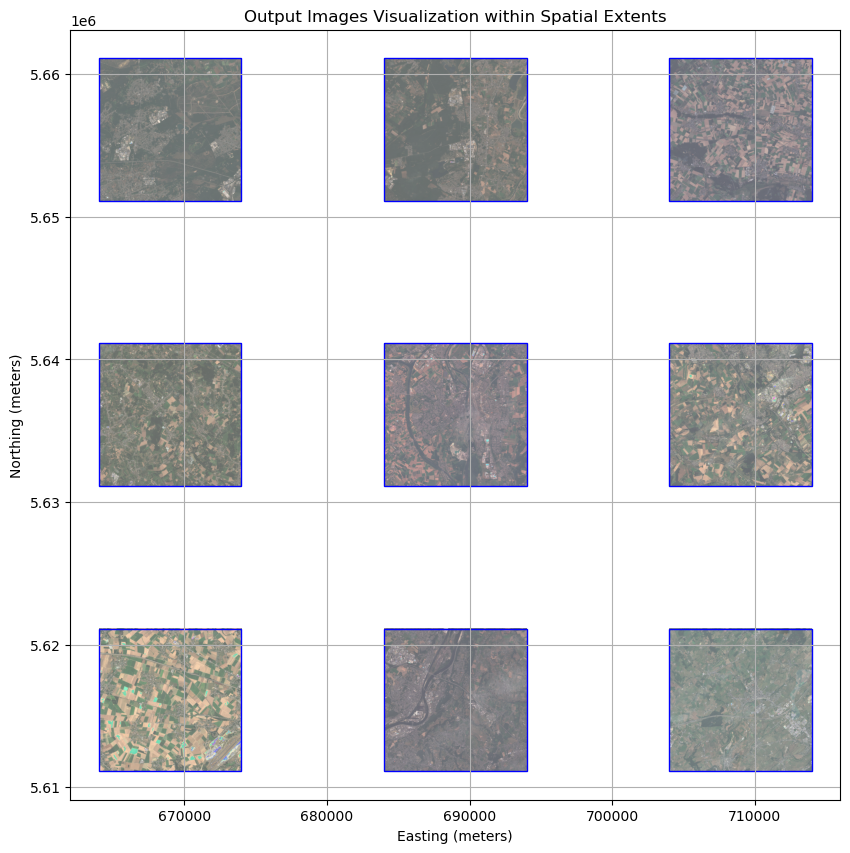

In [11]:

def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min) * 1024).astype(np.uint8)

def visualize_output(output_df: pd.DataFrame, date:str):
    """Visualize output images for finished jobs within their spatial extents."""
    fig, ax = plt.subplots(figsize=(10, 10))
    x_min, x_max, y_min, y_max = float('inf'), float('-inf'), float('inf'), float('-inf')


    # Plot each output image for finished jobs
    for index, row in output_df.iterrows():
        # Convert the spatial_extent string representation back to a dictionary
        extent = row["spatial_extent"]    
        
        image_path = f"job_{row['id']}/openEO_{date}Z.tif"  # Adjust path based on your setup
        
        
        with rasterio.open(image_path) as src:

            band_blue = src.read(1)
            band_green = src.read(2)
            band_red = src.read(3)

            band_blue = normalize(band_blue)
            band_green = normalize(band_green)
            band_red = normalize(band_red)

            rgb_image = np.dstack((band_red, band_green, band_blue))
            
            # Update axis limits based on current extent
            extent_bounds = [extent["west"], extent["east"], extent["south"], extent["north"]]

            x_min = min(x_min, extent["west"])
            x_max = max(x_max, extent["east"])
            y_min = min(y_min, extent["south"])
            y_max = max(y_max, extent["north"])
            
            # Display the image within its extent
            ax.imshow(rgb_image, extent=extent_bounds, origin='upper', cmap='viridis', alpha=0.6)

            # Draw a box around the extent
            ax.add_patch(plt.Rectangle((extent["west"], extent["south"]),
                                        extent["east"] - extent["west"],
                                        extent["north"] - extent["south"],
                                        linewidth=1, edgecolor='blue', facecolor='none'))

    ax.set_xlim(x_min - SPATIAL_WINDOW_GAP/5, x_max + SPATIAL_WINDOW_GAP/5)
    ax.set_ylim(y_min - SPATIAL_WINDOW_GAP/5, y_max + SPATIAL_WINDOW_GAP/5)
    plt.xlabel("Easting (meters)")
    plt.ylabel("Northing (meters)")
    plt.title("Output Images Visualization within Spatial Extents")
    plt.grid(True)
    plt.show()

# Example usage
output_df = pd.read_parquet(job_tracker)
visualize_output(output_df, '2022-07-01')
